# Reserve prices

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from AuctionSimulator.Agents.Sellers import AuctionedObject, Auctioneer
from AuctionSimulator.Agents.Bidders import SimpleBidder
from AuctionSimulator.AuctionHouse import ReservePrice as Rp
from AuctionSimulator.AuctionHouse import AuctionHouse

n_rounds = 1000
n_objects = 100
n_bidders = 130

budgets = np.array([30., 50., 80., 100., 120., 200., 300., 500., 1000.])
budgets_p = np.ones(9) / 9
budgets_init = np.array([np.random.choice(budgets, p=budgets_p) for _ in range(n_bidders)])

auctioned_objects = np.array([AuctionedObject(i, 2.5, np.inf) for i in range(n_objects)])
auctioneer = Auctioneer(auctioned_objects, x0=np.ones(n_objects) * 10)
bidders = np.array([SimpleBidder(budget=budgets_init[i]) for i in range(n_bidders)])

# reserve prices
rp_fun = Rp.gradient_based
rp_params = {'smoothing_rate': 5, 'learning_rate': 0.5}

house = AuctionHouse.Controller(n_rounds, auctioneer, bidders,
                                    reserve_price_function=Rp.gradient_based,
#                                     reserve_price_function_params=None
                                    reserve_price_function_params={'smoothing_rate': 50, 'learning_rate': 0.5}
                               )
house.run()

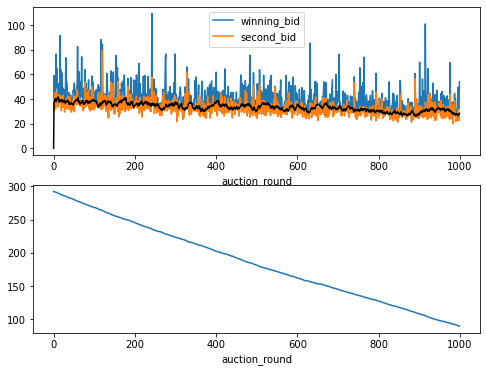

In [2]:
bid_df = house.bidder_tracker.make_dataframe(variables=['bids', 'budgets'])
auc_df = house.auction_tracker.make_dataframe()

plt.rc('figure', figsize=(8, 6))
fig, (ax1, ax2) = plt.subplots(2, 1)
time = np.linspace(0, 24, n_rounds)
auc_df[['winning_bid', 'second_bid']].plot(ax=ax1)
auc_df['reserve_price'].plot(c='k', ax=ax1)
bid_df['budgets'].mean(axis=1).plot(ax=ax2)
plt.show()

In [3]:
auc_df

,object_id,winner,winning_bid,second_bid,payment,reserve_price,fee,time
auction_round,,,,,,,,
0,0.0,98.0,40.312880,35.608512,35.608512,0.000000,0.0,2020-01-01 00:19:01
1,91.0,58.0,59.087802,30.000000,37.960696,37.960696,0.0,2020-01-01 00:20:29
2,64.0,5.0,50.454078,44.482423,44.482423,38.464096,0.0,2020-01-01 00:30:44
3,26.0,84.0,49.893453,45.187199,45.187199,39.445429,0.0,2020-01-01 00:32:08
4,63.0,NaN,35.676657,34.371823,0.000000,40.413118,0.0,2020-01-01 00:36:36
...,...,...,...,...,...,...,...,...
995,98.0,115.0,49.731243,22.657004,26.455286,26.455286,0.0,2020-01-01 23:55:23
996,67.0,115.0,33.663008,31.886946,31.886946,26.997871,0.0,2020-01-01 23:56:25
997,83.0,108.0,31.869241,29.307716,29.307716,27.856468,0.0,2020-01-01 23:56:28


In [12]:
functions = [None, Rp.gradient_based, Rp.one_shot]
params = [None, {'smoothing_rate': 50, 'learning_rate': 0.5}, None]

n_days = 10
revenues = np.zeros((n_days, len(functions)))

for c, fun in enumerate(functions):
    par = params[c]
    for d in range(n_days):
        auctioned_objects = np.array([AuctionedObject(i, 2.5, np.inf) for i in range(n_objects)])
        auctioneer = Auctioneer(auctioned_objects, x0=np.ones(n_objects) * 30)
        bidders = np.array([SimpleBidder(budget=budgets_init[i]) for i in range(n_bidders)])
        house = AuctionHouse.Controller(n_rounds, auctioneer, bidders,
                                        reserve_price_function=fun,
                                        reserve_price_function_params=par, 
                                        track_auctions=True, track_bidders=False
                                       )
        house.run()

        revenues[d,c] = house.auctioneer.revenue

In [14]:
revenues.mean(axis=0)
revenues

array([33077.86971039, 33879.22625263, 31656.63945139])

# Throttling 

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from AuctionSimulator.Agents.Sellers import AuctionedObject, Auctioneer
from AuctionSimulator.Agents.Bidders import SimpleBidder
from AuctionSimulator.AuctionHouse import Throttling as Thr
from AuctionSimulator.AuctionHouse import AuctionHouse

n_rounds = 1000
n_objects = 100
n_bidders = 130

budgets = np.array([30., 50., 80., 100., 120., 200., 300., 500., 1000.])
budgets_p = np.ones(9) / 9
budgets_init = np.array([np.random.choice(budgets, p=budgets_p) for _ in range(n_bidders)])

fees = np.array([0, 0.3, 0.36, 0.68])
fees_p = np.array([0.36, 0.14, 0.30, 0.2])
fees_init = np.array([np.random.choice(fees, p=fees_p) for i in range(n_objects)])

auctioned_objects = np.array([AuctionedObject(i, 3, np.inf, fee=fees_init[i]) for i in range(n_objects)])
auctioneer = Auctioneer(auctioned_objects, x0=np.ones(n_objects) * 0)
bidders = np.array([SimpleBidder(budget=budgets_init[i]) for i in range(n_bidders)])

# throttling
plan = Thr.Planning(n_rounds, budgets_init).sigmoid_planning(s=0.5, t0=13)
# plan = Thr.Planning(n_rounds, budgets_init).uniform_planning()
# plan = Thr.Planning(n_rounds, budgets_init).empirical_planning()
probability_function = Thr.Probability().linear_probability
probability_function_params = {'floor': 0.25}
# probability_function = Thr.Probability().total_probability
# probability_function_params = {'prob_under_plan': 0.1}

house = AuctionHouse.Controller(n_rounds, auctioneer, bidders,
                                throttling=True, 
                                plan=plan, probability_function=probability_function,
                                probability_function_params=probability_function_params
                                )

In [7]:
%%time
house.run()

Wall time: 766 ms


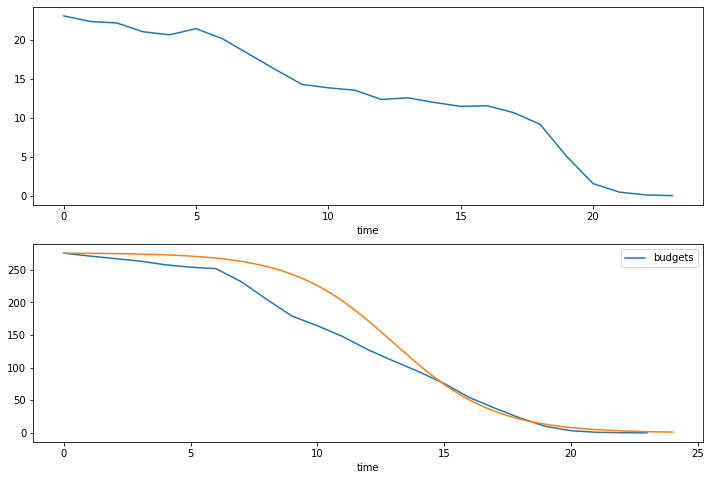

In [8]:
auc_df = house.auction_tracker.make_dataframe()
bid_df = house.bidder_tracker.make_dataframe()

plt.rc('figure', figsize=(12, 8))
fig, (ax1, ax2) = plt.subplots(2, 1)

time = auc_df['time'].dt.hour

df = bid_df['bids'].groupby(time).mean()
df.mean(axis=1).plot(ax=ax1)

df = bid_df['budgets'].groupby(time).max()
df.mean(axis=1).plot(ax=ax2, label='budgets')
ax2.plot(house.time, plan.mean(axis=1))
ax2.legend()
plt.show()

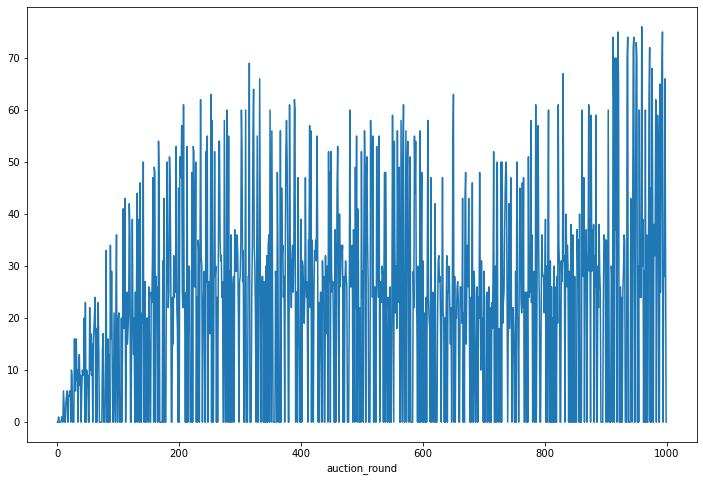

In [9]:
bid_df['decisions'].sum(axis=1).plot()